# Parses through the taxonomy of the Belgium samples.

Some input files are not included, and can be found on zenodo or can be downloaded via NCBI (ncbi taxdump).
Keep in mind the names.dmp / nodes.dmp are reduced (omit '|').

#List of these files:

 - ../../Bee_euvirDATA/data/TotalBP_lowkmer_9780 (zenodo)
 - ../../Bee_euvirDATA/data/namesRED.dmp (NCBI taxonomy/zenodo)
 - ../../Bee_euvirDATA/data/nodesRED.dmp (NCBI taxonomy/zenodo)
 - ../../Bee_euvirDATA/data/EUvirs_refseq_round2.tblx (zenodo)
 - ../../Bee_euvirDATA/data/Pcoa/flembee_df_coverage_lengthnorm.tsv (zenodo)

For reproducability (in the matter of taxDB consistency, download the zenodo data and extract in to the ../../Bee_euvirDATA location.

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib
from graph_tool.all import *
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from statannot import add_stat_annotation
import pylab
import scipy
import warnings
warnings.filterwarnings("ignore")
rcParams.update({'figure.autolayout': True})
plt.rcParams['svg.fonttype'] = 'none'
sns.set(font='arial')
sns.set_style("white")
sns.set_style("ticks")
%matplotlib inline

In [2]:
# Parse pickled taxpaths, and retain viruses (taxonomy ID 10239).
with open('../data/totalscaffolds_size500_9780.pkl', 'rb') as f:
    taxlist = pickle.load(f)
virlist = []
for i in taxlist:
    if 10239 in i:
        virlist.append(i)

In [3]:
# Remove the previously classified bacteriophage sequences. Also remove 3 contigs identified as contamination.
phaglist = []
with open('../data/phagenames_contam.txt') as f:
    for line in f:
        phaglist.append(line.strip())
nophaglist = []
for i in virlist:
    if str(i[0]).replace('scaffolds_','') not in phaglist:
        nophaglist.append(i)
len(nophaglist)

1398

In [4]:
#Before naming them, get the 'rank' of each of the tax ids.
nodes = pd.read_csv("../../Bee_euvirDATA/data/nodesRED.dmp",delimiter='\t',encoding='utf-8')
virdic = {}
for i in nophaglist:
    taxdic = {}
    for j in i:
        if 'NODE' in str(j):
            name = str(j).replace('scaffolds_','')
        else:
            tax = int(j)
            rank = nodes[nodes['tax'] == tax].iat[0,2]
            taxdic[rank] = tax
    virdic[name] = taxdic

In [5]:
#Change taxID numbers into names
names = pd.read_csv("../../Bee_euvirDATA/data/namesRED.dmp",delimiter='\t',encoding='utf-8')
namedic = {}
for i in virdic:
    name = str(i)
    tempdic = {}
    for j in virdic[i]:
        nam = names[names['tax'] == int(virdic[i][j])].iat[0,1]
        tempdic[j] = nam
    namedic[i] = tempdic

In [6]:
#Wrap in dataframe
namedf = pd.DataFrame(namedic)
namedf = namedf.T
namedf['family'].unique()
#Remove Myoviridae,Siphoviridae, Podoviridae
namedf = namedf[namedf['family'] != 'Myoviridae']
namedf = namedf[namedf['family'] != 'Siphoviridae']
namedf = namedf[namedf['family'] != 'Podoviridae']
namedf = namedf[namedf['order'] != 'Caudovirales']
namedf = namedf.fillna('Unclassified')
len(namedf)
namedf.to_csv("../data/notebooks_out/viral_df_taxonomy.csv")

In [7]:
#Write out the dataframe and 
namedf = pd.read_csv("../data/notebooks_out/viral_df_taxonomy.csv", index_col=0)
namedf.head()

,no rank,superkingdom,order,family,genus,species,subfamily,phylum,subphylum,class
BP10_NODE_1166_length_687_cov_0_349823,RNA viruses,Vira,Tymovirales,Alphaflexiviridae,Potexvirus,WClMV,Unclassified,Unclassified,Unclassified,Unclassified
BP10_NODE_1208_length_678_cov_0_166966,unclassified Circoviridae,Vira,Unclassified,Circoviridae,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified
BP10_NODE_1701_length_596_cov_0_267368,unclassified Tymoviridae,Vira,Tymovirales,Tymoviridae,Unclassified,Bee Macula-like virus,Unclassified,Unclassified,Unclassified,Unclassified
BP10_NODE_183_length_2151_cov_1_652217,environmental samples,Vira,Unclassified,Unclassified,Unclassified,uncultured virus,Unclassified,Unclassified,Unclassified,Unclassified
BP10_NODE_2233_length_543_cov_0_462085,unclassified Genomoviridae,Vira,Unclassified,Genomoviridae,Unclassified,Cybaeus spider associated circular virus 2,Unclassified,Unclassified,Unclassified,Unclassified


<AxesSubplot:xlabel='Family', ylabel='Number of sequences'>

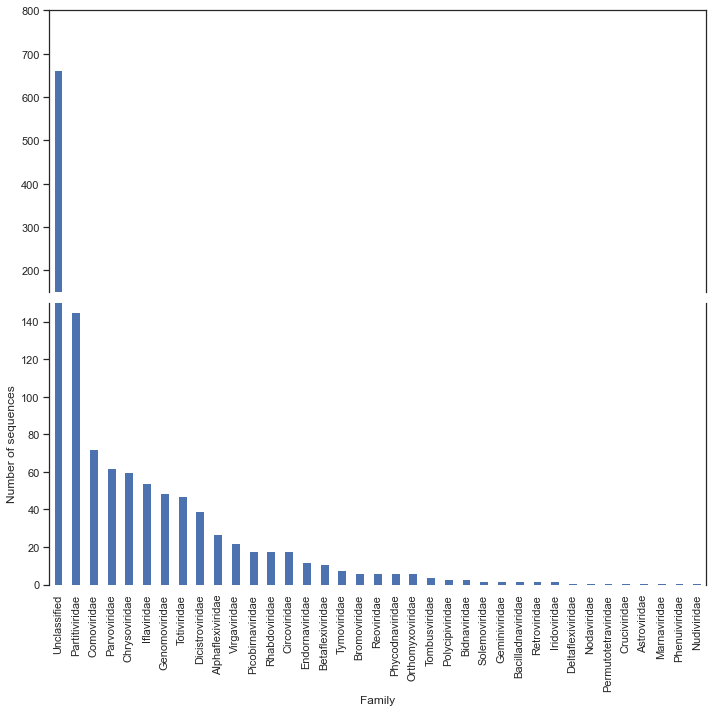

In [8]:
# Countplots for the contigs per taxonomy.
XX = namedf['family'].value_counts()
#XX = XX.sort_index(axis = 0) 
g = fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,
                         figsize=(5,5))

g = ax1.spines['bottom'].set_visible(False)
g = ax2.spines['bottom'].set_visible(False)
g = ax2.spines['top'].set_visible(False)
g = ax1.tick_params(axis='x',which='both',bottom=False)
g = ax2.tick_params(axis='x',which='both',bottom=False)


g = ax2.set_ylim(0,150)
g = ax1.set_ylim(150,800)

g = ax2.set_ylabel("Number of sequences")
g = ax2.set_xlabel("Family")
g = XX.plot(ax=ax1,kind='bar',figsize=(10,10))
g = XX.plot(ax=ax2,kind='bar',figsize=(10,10))
g
#g.figure.savefig('figures/familycount.png', dpi=300)

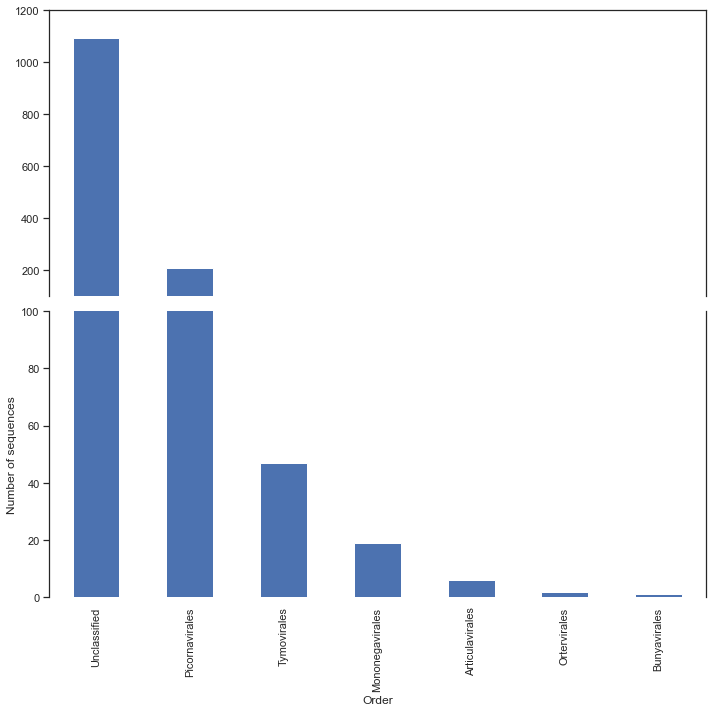

<Figure size 720x720 with 0 Axes>

In [9]:
#Same plot per order.
#Order counts:
XX = namedf['order'].value_counts()
g = fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,
                         figsize=(5,5))

g = ax1.spines['bottom'].set_visible(False)
g = ax2.spines['bottom'].set_visible(False)
g = ax2.spines['top'].set_visible(False)
g = ax1.tick_params(axis='x',which='both',bottom=False)
g = ax2.tick_params(axis='x',which='both',bottom=False)


g = ax2.set_ylim(0,100)
g = ax1.set_ylim(100,1200)

g = ax2.set_ylabel("Number of sequences")
g = ax2.set_xlabel("Order")
g = XX.plot(ax=ax1,kind='bar',figsize=(10,10))
g = XX.plot(ax=ax2,kind='bar',figsize=(10,10))

plt.figure(figsize=(10,10))
plt.tight_layout()
#g.figure.savefig('figures/Ordercount.png', dpi=300)

In [10]:
## Heatmap per family.
#read in coverage counts (full dataset!), so we have to subset. 
#Dead and alive lists:
Dead = ['BP2','BP4','BP7','BP8','BP9','BP12','BP14','BP15','BP18','BP20','BP22','BP24','BP25','BP27','BP30','BP31','BP32','BP33','BP36','BP38','BP40','BP42','BP44','BP47','BP48','BeeP.01.2013','BeeP.04.2013','BeeP.05.2013','BeeP.07.2013','BeeP.09.2013','BeeP.11.2013','BeeP.13.2013','BeeP.15.2013','BeeP.16.2013','BeeP.18.2013','BeeP.19.2013','BeeP.23.2013','BeeP.24.2013','BeeP.26.2013','BeeP.29.2013','BeeP.31.2013','BeeP.33.2013','BeeP.34.2013','BeeP.37.2013','BeeP.38.2013','BeeP.41.2013','BeeP.44.2013','BeeP.46.2013','BeeP.48.2013','BeeP.50.2013','BeeP.Q2.2013']
Alive = ['BP1','BP3','BP5','BP6','BP10','BP11','BP13','BP16','BP17','BP19','BP21','BP23','BP26','BP26','BP28','BP29','BP34','BP35','BP37','BP39','BP41','BP43','BP45','BP46','BP49','BP50','BeeP.02.2013','BeeP.03.2013','BeeP.06.2013','BeeP.08.2013','BeeP.10.2013','BeeP.12.2013','BeeP.14.2013','BeeP.17.2013','BeeP.20.2013','BeeP.21.2013','BeeP.22.2013','BeeP.25.2013','BeeP.27.2013','BeeP.28.2013','BeeP.30.2013','BeeP.32.2013','BeeP.35.2013','BeeP.36.2013','BeeP.39.2013','BeeP.40.2013','BeeP.42.2013','BeeP.43.2013','BeeP.45.2013','BeeP.47.2013','BeeP.49.2013','BeeP.Q1.2013']
#the flembee cov matrix is build on the entire mappings, in this case we only want the 'NODEs'
vircovdf = pd.read_csv("../data/Pcoa/flembee_df_coverage_lengthnorm.tsv", sep=",", index_col=0)
#grep 'NODES'
keepnodes = []
for i in vircovdf.index:
    if 'NODE' in i:
        keepnodes.append(i)
vircovdf = vircovdf[vircovdf.index.isin(keepnodes)]
vircovdf = vircovdf*150

In [12]:
# Add the percentage of similarity to each contig.
simdic = {}
with open('../../Bee_euvirDATA/data/TotalBP_lowkmer_9780.m8') as f:
    for line in f:
        if line.strip().split()[0] in vircovdf.index:
            if line.strip().split()[0] not in simdic:
                simdic[line.strip().split()[0]] = [float(line.strip().split()[2]), int(line.strip().split()[3])]
            else:
                if int(line.strip().split()[3]) > simdic[line.strip().split()[0]][1]:
                    simdic[line.strip().split()[0]] = [float(line.strip().split()[2]), int(line.strip().split()[3])]
simdf = pd.DataFrame(simdic)
simdf = simdf.T
simdf.columns = ['Similarity','Al_len']

In [13]:
#Average over per family
familylist = list(namedf['family'].unique())
Alphaflexiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Alphaflexiviridae'].index))]
Circoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Circoviridae'].index))]
Tymoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Tymoviridae'].index))]
Unclassified = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Unclassified'].index))]
Genomoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Genomoviridae'].index))]
Parvoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Parvoviridae'].index))]
Dicistroviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Dicistroviridae'].index))]
Rhabdoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Rhabdoviridae'].index))]
Picobirnaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Picobirnaviridae'].index))]
Partitiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Partitiviridae'].index))]
Retroviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Retroviridae'].index))]
Reoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Reoviridae'].index))]
Iflaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Iflaviridae'].index))]
Iridoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Iridoviridae'].index))]
Totiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Totiviridae'].index))]
Chrysoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Chrysoviridae'].index))]
Virgaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Virgaviridae'].index))]
Comoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Comoviridae'].index))]
Phycodnaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Phycodnaviridae'].index))]
Cruciviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Cruciviridae'].index))]
Bidnaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Bidnaviridae'].index))]
Orthomyxoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Orthomyxoviridae'].index))]
Endornaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Endornaviridae'].index))]
Solemoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Solemoviridae'].index))]
Permutotetraviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Permutotetraviridae'].index))]
Marnaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Marnaviridae'].index))]
Deltaflexiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Deltaflexiviridae'].index))]
Tombusviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Tombusviridae'].index))]
Geminiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Geminiviridae'].index))]
Bacilladnaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Bacilladnaviridae'].index))]
Bromoviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Bromoviridae'].index))]
Nodaviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Nodaviridae'].index))]
Polycipiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Polycipiviridae'].index))]
Betaflexiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Betaflexiviridae'].index))]
Nudiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Nudiviridae'].index))]
Phenuiviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Phenuiviridae'].index))]
Astroviridae = vircovdf[vircovdf.index.isin(list(namedf[namedf['family'] == 'Astroviridae'].index))]
Alphaflexiviridae = Alphaflexiviridae.mean()
Circoviridae = Circoviridae.mean()
Tymoviridae = Tymoviridae.mean()
Unclassified = Unclassified.mean()
Genomoviridae = Genomoviridae.mean()
Parvoviridae = Parvoviridae.mean()
Dicistroviridae = Dicistroviridae.mean()
Rhabdoviridae = Rhabdoviridae.mean()
Picobirnaviridae = Picobirnaviridae.mean()
Partitiviridae = Partitiviridae.mean()
Retroviridae = Retroviridae.mean()
Reoviridae = Reoviridae.mean()
Iflaviridae = Iflaviridae.mean()
Iridoviridae = Iridoviridae.mean()
Totiviridae = Totiviridae.mean()
Chrysoviridae = Chrysoviridae.mean()
Virgaviridae = Virgaviridae.mean()
Comoviridae = Comoviridae.mean()
Phycodnaviridae = Phycodnaviridae.mean()
Cruciviridae = Cruciviridae.mean()
Bidnaviridae = Bidnaviridae.mean()
Orthomyxoviridae = Orthomyxoviridae.mean()
Endornaviridae = Endornaviridae.mean()
Solemoviridae = Solemoviridae.mean()
Permutotetraviridae = Permutotetraviridae.mean()
Marnaviridae = Marnaviridae.mean()
Deltaflexiviridae = Deltaflexiviridae.mean()
Tombusviridae = Tombusviridae.mean()
Geminiviridae = Geminiviridae.mean()
Bacilladnaviridae = Bacilladnaviridae.mean()
Bromoviridae = Bromoviridae.mean()
Nodaviridae = Nodaviridae.mean()
Polycipiviridae = Polycipiviridae.mean()
Betaflexiviridae = Betaflexiviridae.mean()
Nudiviridae = Nudiviridae.mean()
Phenuiviridae = Phenuiviridae.mean()
Astroviridae = Astroviridae.mean()

<Figure size 720x720 with 0 Axes>

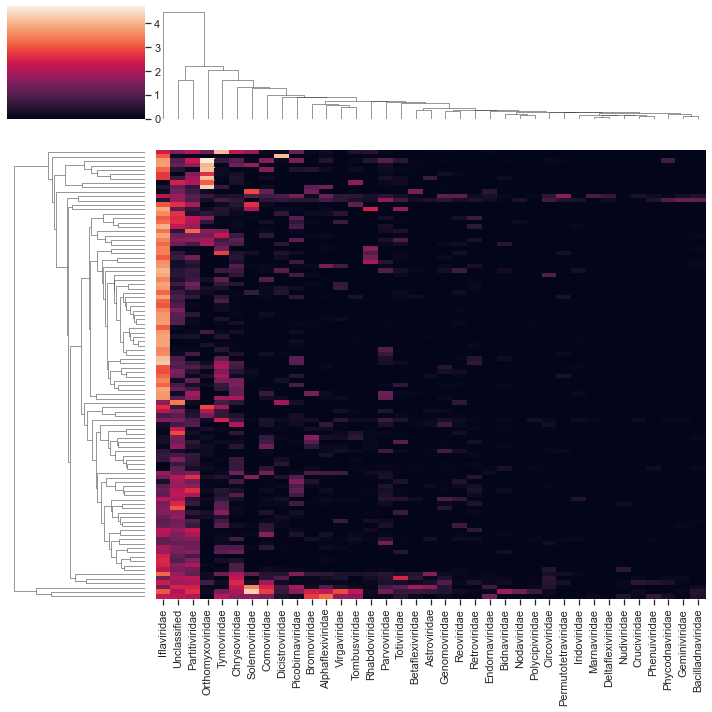

In [14]:
famcov_average = pd.concat([Alphaflexiviridae,Circoviridae,Tymoviridae,Unclassified,Genomoviridae,Parvoviridae,Dicistroviridae,Rhabdoviridae,Picobirnaviridae,Partitiviridae,Retroviridae,Reoviridae,Iflaviridae,Iridoviridae,Totiviridae,Chrysoviridae,Virgaviridae,Comoviridae,Phycodnaviridae,Cruciviridae,Bidnaviridae,Orthomyxoviridae,Endornaviridae,Solemoviridae,Permutotetraviridae,Marnaviridae,Deltaflexiviridae,Tombusviridae,Geminiviridae,Bacilladnaviridae,Bromoviridae,Nodaviridae,Polycipiviridae,Betaflexiviridae,Nudiviridae,Phenuiviridae,Astroviridae], axis=1, sort=False)
famcov_average.columns = ['Alphaflexiviridae','Circoviridae','Tymoviridae','Unclassified','Genomoviridae','Parvoviridae','Dicistroviridae','Rhabdoviridae','Picobirnaviridae','Partitiviridae','Retroviridae','Reoviridae','Iflaviridae','Iridoviridae','Totiviridae','Chrysoviridae','Virgaviridae','Comoviridae','Phycodnaviridae','Cruciviridae','Bidnaviridae','Orthomyxoviridae','Endornaviridae','Solemoviridae','Permutotetraviridae','Marnaviridae','Deltaflexiviridae','Tombusviridae','Geminiviridae','Bacilladnaviridae','Bromoviridae','Nodaviridae','Polycipiviridae','Betaflexiviridae','Nudiviridae','Phenuiviridae','Astroviridae']
plt.figure(figsize=(10,10))
g = sns.clustermap(np.log10(famcov_average + 1), yticklabels=False, xticklabels=True)
g
#g.savefig('figures/Famcoverage_average_counts.png', dpi=300)

<Figure size 1440x1440 with 0 Axes>

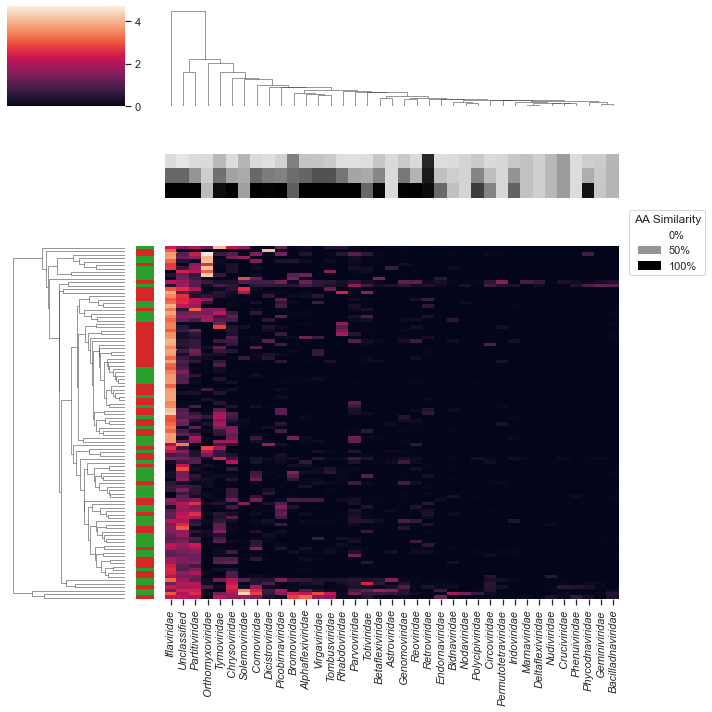

In [15]:
#1 more, but also collapse DF on healthy & alive.
statlist = []
for i in list(famcov_average.index):
    if i in Dead:
        statlist.append('#d62728')
    if i in Alive:
        statlist.append('#2ca02c')
virfamlist = ['Alphaflexiviridae','Circoviridae','Tymoviridae','Unclassified','Genomoviridae','Parvoviridae','Dicistroviridae','Rhabdoviridae','Picobirnaviridae','Partitiviridae','Retroviridae','Reoviridae','Iflaviridae','Iridoviridae','Totiviridae','Chrysoviridae','Virgaviridae','Comoviridae','Phycodnaviridae','Cruciviridae','Bidnaviridae','Orthomyxoviridae','Endornaviridae','Solemoviridae','Permutotetraviridae','Marnaviridae','Deltaflexiviridae','Tombusviridae','Geminiviridae','Bacilladnaviridae','Bromoviridae','Nodaviridae','Polycipiviridae','Betaflexiviridae','Nudiviridae','Phenuiviridae','Astroviridae']
minsim = []
maxsim = []
avsim = []
for i in virfamlist:
    minsim.append(min(simdf[simdf.index.isin(list(namedf[namedf['family'] == i].index))]['Similarity'])/100)
    maxsim.append(max(simdf[simdf.index.isin(list(namedf[namedf['family'] == i].index))]['Similarity'])/100)
    avsim.append((simdf[simdf.index.isin(list(namedf[namedf['family'] == i].index))]['Similarity']).mean()/100)
#Set up in colors:
Blues = plt.get_cmap('Greys')
minsim_col = []
for i in minsim:
    minsim_col.append(Blues(i))

maxsim_col = []    
for i in maxsim:
    maxsim_col.append(Blues(i))  

avsim_col = []
for i in avsim:
    avsim_col.append(Blues(i))

plt.figure(figsize=(20,20))
g = sns.clustermap(np.log10(famcov_average + 1), row_colors=statlist, col_colors=[minsim_col,avsim_col,maxsim_col])
g.ax_heatmap.set(yticklabels=[],yticks=[])
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontstyle='italic')
legend_TN = [mpatches.Patch(color=matplotlib.colors.to_hex(Blues(0)[:3]), label='0%'),mpatches.Patch(color=matplotlib.colors.to_hex(Blues(0.5)[:3]), label='50%'),mpatches.Patch(color=matplotlib.colors.to_hex(Blues(1.0)[:3]), label='100%')]
legend_TN2 = [mpatches.Patch(color='#d62728', label='Weak'), mpatches.Patch(color='#2ca02c', label='Healthy')]
g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,1.01),handles=legend_TN,frameon=True, title='AA Similarity')
g
#g.set_tight_layout(False)
#g.savefig('figures/famcov_status_simlegend.png', bbox_inches='tight', dpi=1000)

<Figure size 1440x1440 with 0 Axes>

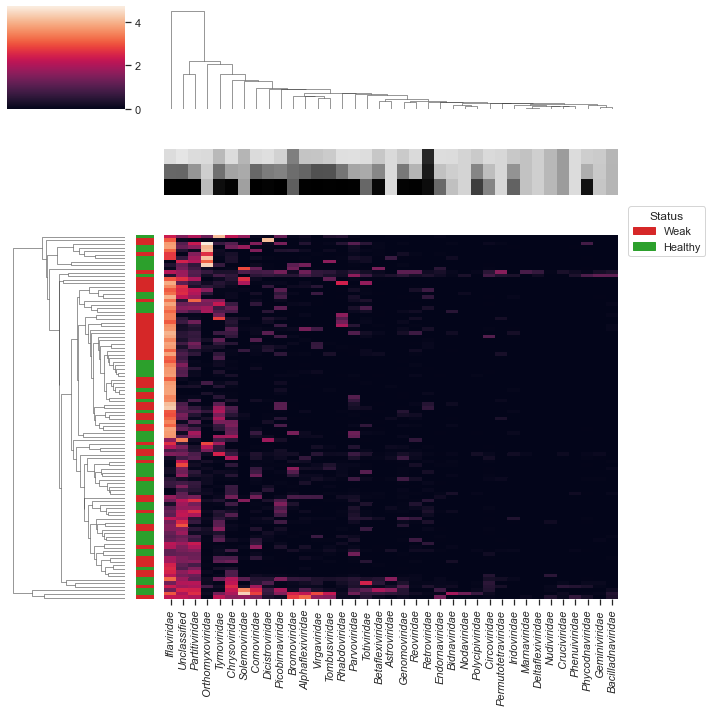

In [16]:
#The same plot, but with another legend.
statlist = []
for i in list(famcov_average.index):
    if i in Dead:
        statlist.append('#d62728')
    if i in Alive:
        statlist.append('#2ca02c')
virfamlist = ['Alphaflexiviridae','Circoviridae','Tymoviridae','Unclassified','Genomoviridae','Parvoviridae','Dicistroviridae','Rhabdoviridae','Picobirnaviridae','Partitiviridae','Retroviridae','Reoviridae','Iflaviridae','Iridoviridae','Totiviridae','Chrysoviridae','Virgaviridae','Comoviridae','Phycodnaviridae','Cruciviridae','Bidnaviridae','Orthomyxoviridae','Endornaviridae','Solemoviridae','Permutotetraviridae','Marnaviridae','Deltaflexiviridae','Tombusviridae','Geminiviridae','Bacilladnaviridae','Bromoviridae','Nodaviridae','Polycipiviridae','Betaflexiviridae','Nudiviridae','Phenuiviridae','Astroviridae']
minsim = []
maxsim = []
avsim = []
for i in virfamlist:
    minsim.append(min(simdf[simdf.index.isin(list(namedf[namedf['family'] == i].index))]['Similarity'])/100)
    maxsim.append(max(simdf[simdf.index.isin(list(namedf[namedf['family'] == i].index))]['Similarity'])/100)
    avsim.append((simdf[simdf.index.isin(list(namedf[namedf['family'] == i].index))]['Similarity']).mean()/100)
#Set up in colors:
Blues = plt.get_cmap('Greys')
minsim_col = []
for i in minsim:
    minsim_col.append(Blues(i))

maxsim_col = []    
for i in maxsim:
    maxsim_col.append(Blues(i))  

avsim_col = []
for i in avsim:
    avsim_col.append(Blues(i))

plt.figure(figsize=(20,20))
g = sns.clustermap(np.log10(famcov_average + 1), row_colors=statlist, col_colors=[minsim_col,avsim_col,maxsim_col])
g.ax_heatmap.set(yticklabels=[],yticks=[])
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontstyle='italic')
legend_TN = [mpatches.Patch(color=matplotlib.colors.to_hex(Blues(0)[:3]), label='0%'),mpatches.Patch(color=matplotlib.colors.to_hex(Blues(0.5)[:3]), label='50%'),mpatches.Patch(color=matplotlib.colors.to_hex(Blues(1.0)[:3]), label='100%')]
legend_TN2 = [mpatches.Patch(color='#d62728', label='Weak'), mpatches.Patch(color='#2ca02c', label='Healthy')]
g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,1.01),handles=legend_TN2,frameon=True, title='Status')
g
#g.set_tight_layout(False)
#g.savefig('figures/famcov_status_statlegend.png', dpi=1000, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Weak v.s. Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.731e-01 U_stat=1.167e+03


(<AxesSubplot:xlabel='Status', ylabel='Contig count'>,
 [<statannot.StatResult.StatResult at 0x7f82a8bf0b80>])

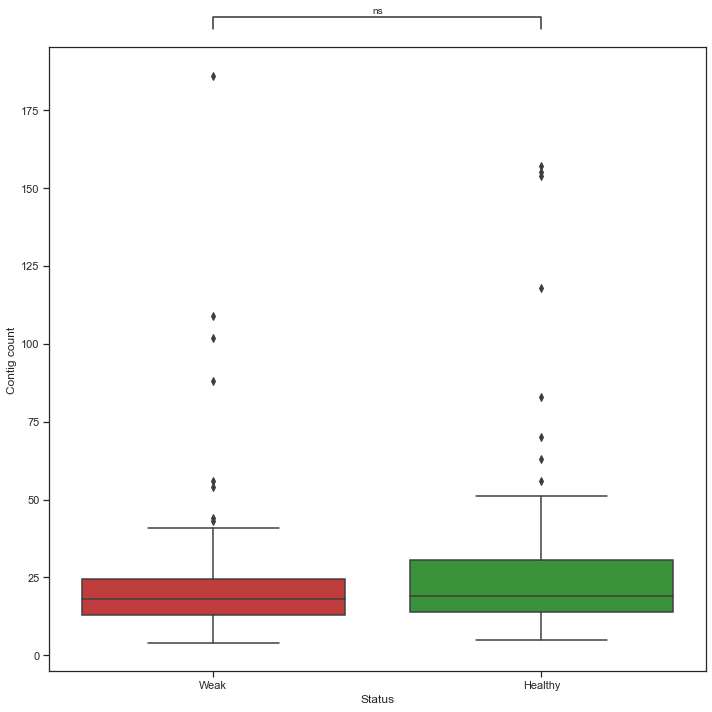

In [17]:
#Is there a difference in total contig count between healthy and weak samples?
status_countdic = {}
status_countdic['Healthy'] = []
status_countdic['Weak'] = []
for i in dict(vircovdf[vircovdf > 10.0].count()):
    if i in Alive:
        status_countdic['Healthy'].append(dict(vircovdf[vircovdf > 10.0].count())[i])
    if i in Dead:
        status_countdic['Weak'].append(dict(vircovdf[vircovdf > 10.0].count())[i])
status_countdf = pd.DataFrame.from_dict(status_countdic).melt()
status_countdf.columns = ['Status','Contig count']
plt.figure(figsize=(10,10))
g = sns.boxplot(data=status_countdf, x='Status',y='Contig count', palette={"Weak":"#d62728","Healthy":"#2ca02c"}, order=['Weak','Healthy'])
add_stat_annotation(g, data=status_countdf, x='Status', y='Contig count', order=['Weak','Healthy'],
                    box_pairs=[("Weak", "Healthy")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
#g.figure.savefig('figures/Numncontig_MWU.png', dpi=300, bbox_inches='tight')

In [18]:
scipy.stats.mannwhitneyu(status_countdf[status_countdf['Status'] == 'Healthy']['Contig count'], status_countdf[status_countdf['Status'] == 'Weak']['Contig count'])

MannwhitneyuResult(statistic=1167.0, pvalue=0.18654455830388844)

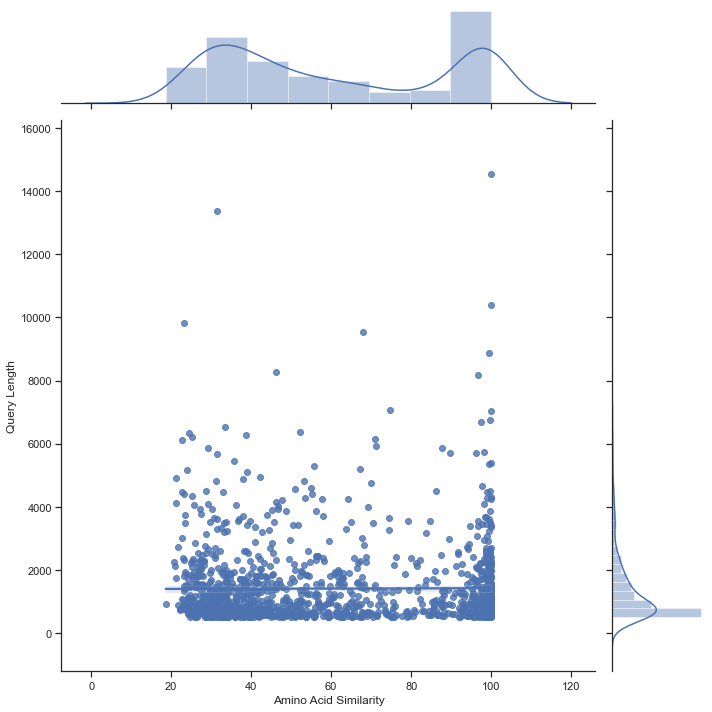

In [19]:
conlen = []
for i in list(simdf.index):
    conlen.append(int(i.split('_')[4]))
simdf['Length'] = conlen
simdf
simdf.columns = ['Amino Acid Similarity','Al_len','Query Length']
g = sns.JointGrid(y="Query Length", x="Amino Acid Similarity", data=simdf, height=10)
g = g.plot(sns.regplot, sns.distplot)
g
#g.savefig('figures/LenvsSim.png', dpi=300, bbox_inches='tight')

In [20]:
#Percentages of bins:
print('fraction of contigs with higher similarity than 90% : ' + str(sum(simdf['Amino Acid Similarity'] > 90)/len(simdf)))
print('fraction of contigs with lower or equal than 90% : ' + str(sum(simdf['Amino Acid Similarity'] <= 90)/len(simdf)))
print('fraction of contigs smaller than 2kb : ' + str(sum(simdf['Query Length'] < 1000)/len(simdf)))

fraction of contigs with higher similarity than 90% : 0.29591836734693877
fraction of contigs with lower or equal than 90% : 0.7040816326530612
fraction of contigs smaller than 2kb : 0.5400874635568513


<AxesSubplot:xlabel='Number of Pools', ylabel='Number of contigs'>

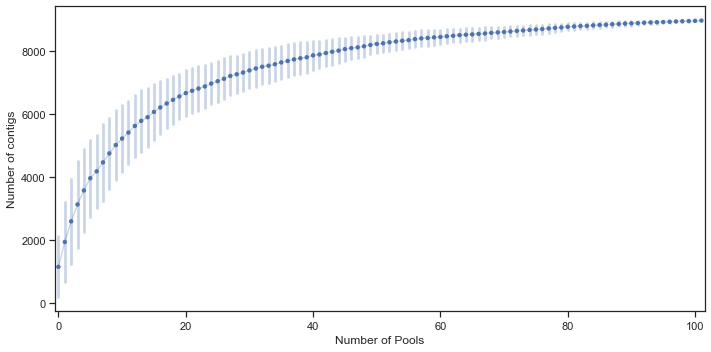

In [21]:
## Species accumulation curves.
spec = pd.read_csv("../data/speccaccummat.csv", sep=",", index_col=0)
spec['idvar'] = spec.index
spec = pd.melt(spec, id_vars=['idvar'])

plt.figure(figsize=(10,5))

g = sns.pointplot(spec['idvar'], spec['value'],ci="sd", scale=0.5)
g.set(xlabel="Number of Pools",ylabel="Number of contigs")
g.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
g.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.setp(g.lines, alpha=.3)
g
#g.figure.savefig('figures/specaccum.png', dpi=300)

In [20]:
############################################### Graphs below ###############################################

In [23]:
## Plot viruses in a graph with refseqs.
tblx = []
#Read in tblx output.
with open('../../Bee_euvirDATA/data/EUvirs_refseq_round2.tblx') as f:
    for line in f:
        if line.strip().split()[0] != line.strip().split()[1] and float(line.strip().split()[10]) < 1e-15:
            tblx.append(line.strip().split())
interactdir = {}
for i in tblx:
    couplestr = str(i[0]) + '|' + str(i[1])
    revcouplestr = str(i[1]) + '|' + str(i[0])
    bit = float(i[11])
    if couplestr in interactdir:
        if interactdir[couplestr] < bit:
            interactdir[couplestr] = bit
    if revcouplestr in interactdir:
        if interactdir[revcouplestr] < bit:
            interactdir[revcouplestr] = bit
    else:
        interactdir[couplestr] = bit
tblx_network = []
for i in interactdir:
    str1 = i.split('|')[0]
    str2 = i.split('|')[1]
    bit = interactdir[i]
    tblx_network.append([str1,str2,bit])

In [24]:
g = Graph(directed=False)
allvert = {}
v_prop = g.new_vertex_property("string")
e_prop = g.new_edge_property("float")
counter = 0
for i in tblx_network:
    if i[0] not in allvert:
        allvert[i[0]] = counter
        counter += 1
        e = g.add_vertex()
        if 'NODE' in i[0]:
            v_prop[e] = 'red'
        else:
            v_prop[e] = 'grey'
    if i[1] not in allvert:
        allvert[i[1]] = counter
        counter += 1
        e = g.add_vertex()
        if 'NODE' in i[1]:
            v_prop[e] = 'red'
        else:
            v_prop[e] = 'grey'
    e = g.add_edge(allvert[i[0]], allvert[i[1]])
    e_prop[e] = i[2]

In [23]:
#Write the graph for viz in cytoscape / gephi.
#Wrap network in df.
#tblxdf = pd.DataFrame(tblx_network)
#tblxdf.to_csv('../data/notebooks_out/Tblx_network.csv',index=False,header=False)

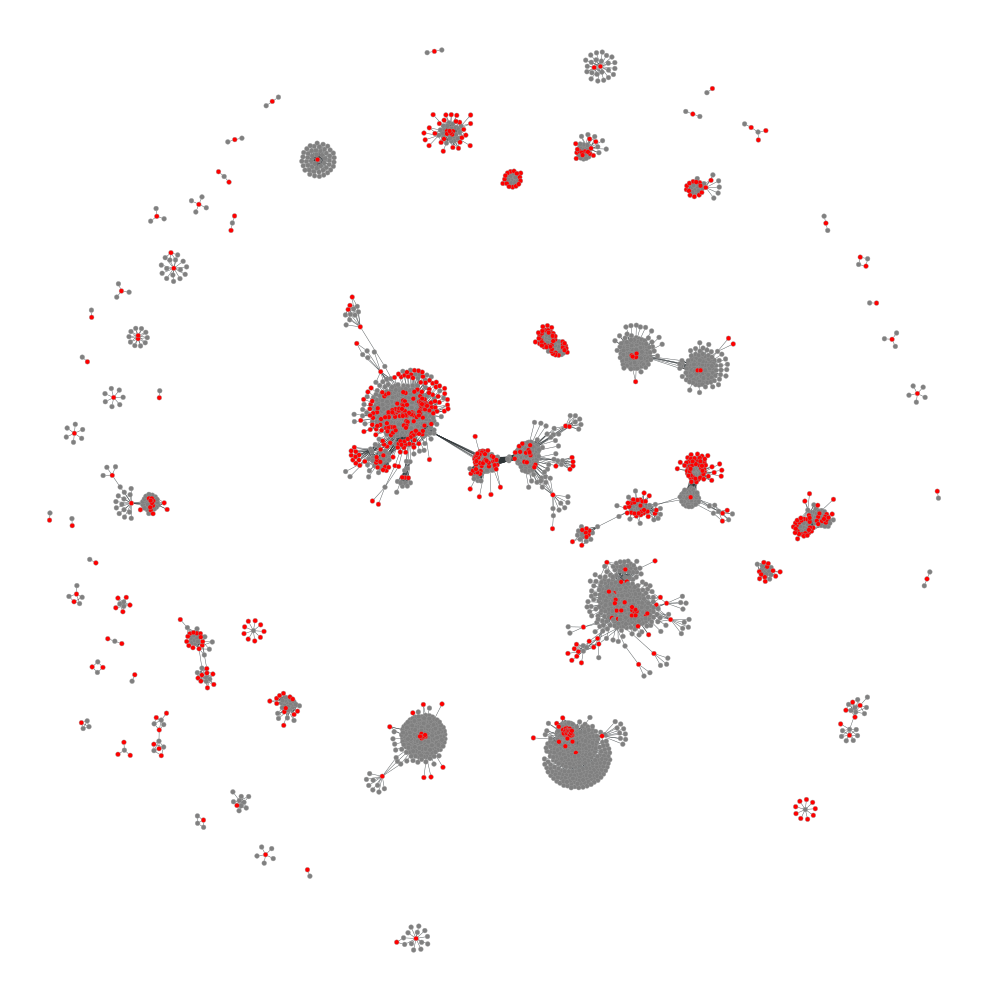

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f827ba3c520, at 0x7f827ee7a280>

In [25]:
graph_draw(g, vertex_fill_color=v_prop ,output_size=(500, 500))

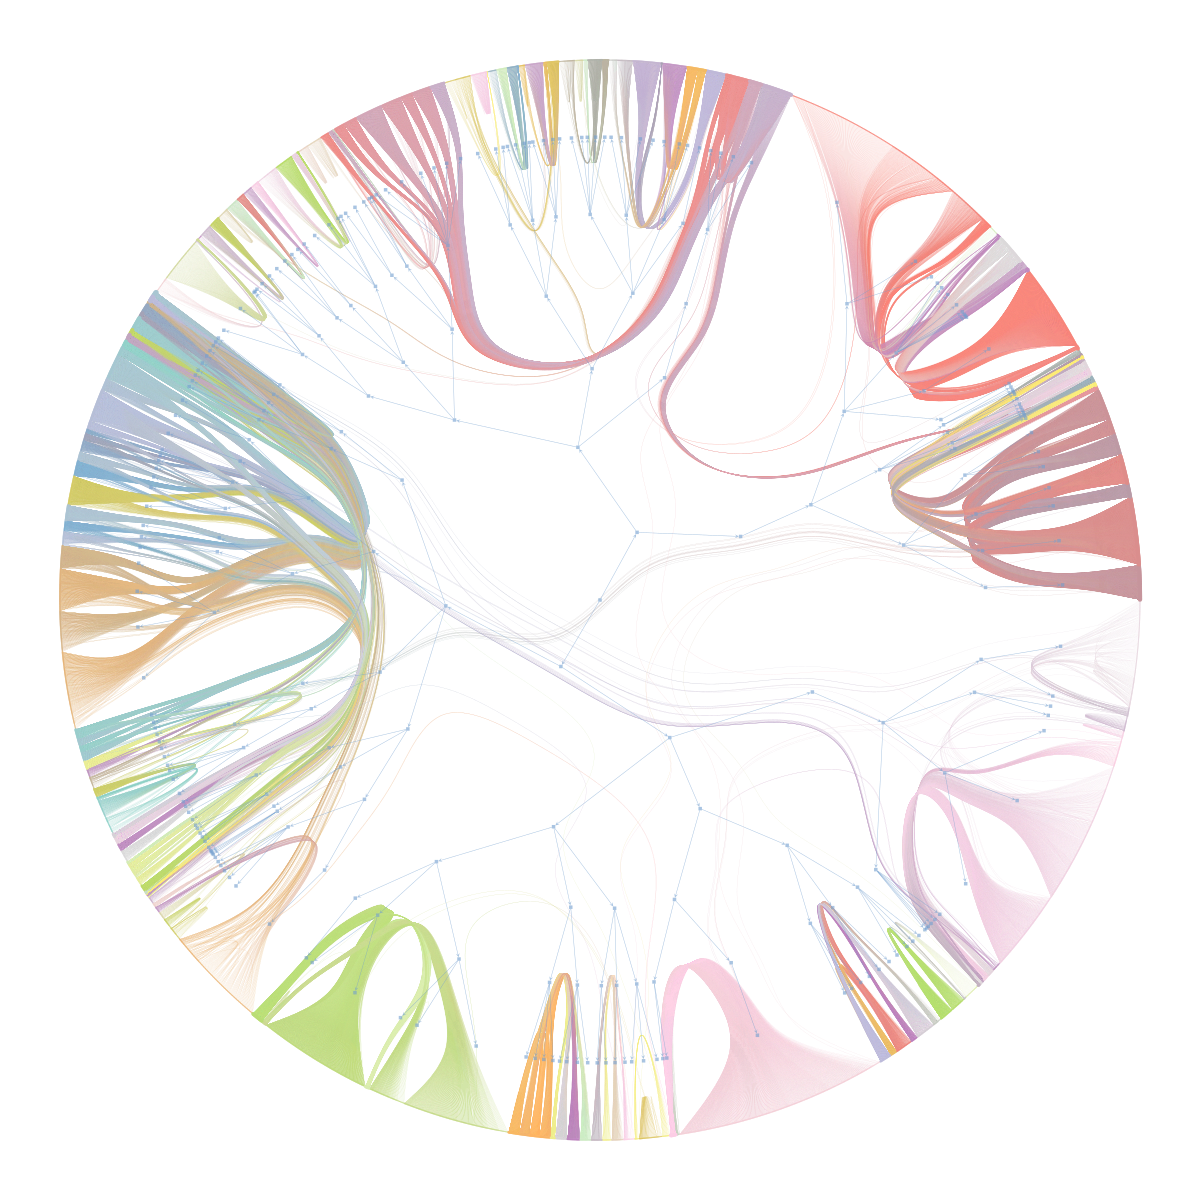

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f827ba3c520, at 0x7f82871a67c0>,
 <Graph object, directed, with 3967 vertices and 3966 edges, at 0x7f82a79712e0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f82a79712e0, at 0x7f827ed5ed60>)

In [26]:
state_dc = minimize_nested_blockmodel_dl(g, deg_corr=False)
draw_hierarchy(state_dc)

In [27]:
## Grab the taxonomy of the reference sequences.
reflist = []
for i in tblx_network:
    if 'NODE' not in i[0] and i[0].split('.')[0] not in reflist:
        reflist.append(i[0].split('.')[0])
    if 'NODE' not in i[1] and i[1].split('.')[0] not in reflist:
        reflist.append(i[1].split('.')[0])

In [28]:
#Grab the tax ID.
ProgressBar().register()
dask_df = dd.read_csv('../../Bee_euvirDATA/data/nucl_gb.accession2taxid', header=0, sep='\t')
dask_df.npartitions
taxdask = dask_df[dask_df['accession'].isin(reflist)]
taxlist = taxdask.compute()

[                                        ] | 0% Completed |  5.9s


KeyboardInterrupt: 

In [47]:
reftaxlist = []
for i in list(taxlist['accession']):
    taxid = list(taxlist[taxlist['accession'] == i]['taxid'])[0]
    reftaxlist.append([i,taxid])
#Pickle the list (run tax.py script outside of jupyter).
#with open('../data/notebooks_out/refstaxlist.pkl', 'wb') as f:
#    pickle.dump(reftaxlist, f)

In [50]:
#Run the tax.py script on the pickled list to get taxpaths.
with open('../data/notebooks_out/refhits_taxpath.pkl', 'rb') as f:
    reftaxpath = pickle.load(f)
#Before naming them, get the 'rank' of each of the tax ids.
nodes = pd.read_csv("../data/nodesRED.dmp",delimiter='\t',encoding='utf-8')
refdic = {}
for i in reftaxpath:
    taxdic = {}
    for j in i:
        if 'NC' in str(j):
            name = str(j)
        else:
            tax = int(j)
            rank = nodes[nodes['tax'] == tax].iat[0,2]
            taxdic[rank] = tax
    refdic[name] = taxdic

In [51]:
#Change taxID numbers into names
names = pd.read_csv("../data/namesRED.dmp",delimiter='\t',encoding='utf-8')
namedic = {}
for i in refdic:
    name = str(i)
    tempdic = {}
    for j in refdic[i]:
        nam = names[names['tax'] == int(refdic[i][j])].iat[0,1]
        tempdic[j] = nam
    namedic[i] = tempdic

In [52]:
refnamedf = pd.DataFrame(namedic)
refnamedf = refnamedf.T
refnamedf = refnamedf.fillna('Unclassified')
famref = {}
for i in refnamedf.index:
    if refnamedf.loc[i,]['order'] in famref:
        famref[refnamedf.loc[i,]['order']].append(i)
    else:
        famref[refnamedf.loc[i,]['order']] = [i]
famref.keys()

dict_keys(['Mononegavirales', 'Unclassified', 'Tymovirales', 'Picornavirales', 'Ortervirales', 'Articulavirales', 'Bunyavirales', 'Jingchuvirales', 'Herpesvirales'])

In [53]:
#Create coldic:
refcol = {}
counter = 0
parvocounter = 0
partiticounter = 0
for i in famref:
    if i == 'Picornavirales':
        for j in famref[i]:
            refcol[j] = '#1f77b4'
    if i == 'Mononegavirales':
        for j in famref[i]:
            refcol[j] = '#2ca02c'
    if i == 'Unclassified':
        for j in famref[i]:
            if j in list(refnamedf[refnamedf['family']  == 'Partitiviridae'].index):
                refcol[j] = '#9467bd'
                partiticounter += 1
            if j in list(refnamedf[refnamedf['family']  == 'Parvoviridae'].index):
                refcol[j] = '#8c564b'
                parvocounter += 1
            if j in list(refnamedf[refnamedf['family']  == 'Chrysoviridae'].index):
                refcol[j] = '#bcbd22'
            if j in list(refnamedf[refnamedf['family']  == 'Genomoviridae'].index):
                refcol[j] = '#17becf'
            if j in list(refnamedf[refnamedf['family']  == 'Totiviridae'].index):
                refcol[j] = '#9acd32'
            if j in list(refnamedf[refnamedf['species']  == 'Sinaivirus'].index):
                refcol[j] = '#ff8c69'
            else:
                refcol[j] = '#7f7f7f'
            refcol[j] = '#bcbd22'
            refcol[j] = '#7f7f7f'
    if i == 'Tymovirales':
        for j in famref[i]:
            refcol[j] = '#ff7f0e'
    if i == 'Ortervirales':
        for j in famref[i]:
            refcol[j] = '#7f7f7f'
    if i == 'Articulavirales':
        for j in famref[i]:
            refcol[j] = '#9467bd'
    if i == 'Bunyavirales':
        for j in famref[i]:
            refcol[j] = '#e377c2'
    if i == 'Jingchuvirales':
        for j in famref[i]:
            refcol[j] = '#7f7f7f'
    if i == 'Herpesvirales':
        for j in famref[i]:
            refcol[j] = '#7f7f7f'
for i in famref:
    print(str(i) + ' ' + str(len(famref[i])))
print('parvos :' + str(parvocounter))
print('partitis: ' + str(partiticounter))

Mononegavirales 196
Unclassified 2340
Tymovirales 231
Picornavirales 297
Ortervirales 28
Articulavirales 26
Bunyavirales 57
Jingchuvirales 4
Herpesvirales 1
parvos :42
partitis: 137


In [54]:
#Recreate network in colors:
g = Graph(directed=False)
allvert = {}
v_prop = g.new_vertex_property("string")
e_prop = g.new_edge_property("float")
name_prop = g.new_vertex_property("string")
counter = 0
for i in tblx_network:
    if i[0] not in allvert:
        allvert[i[0]] = counter
        counter += 1
        e = g.add_vertex()
        if 'NODE' in i[0]:
            v_prop[e] = '#d62728'
            name_prop[e] = 'Node'
        else:
            name_prop[e] = str(i[0])
            if i[0].split('.')[0] in refcol:
                v_prop[e] = refcol[i[0].split('.')[0]]
            else:
                v_prop[e] = '#7f7f7f'
    if i[1] not in allvert:
        allvert[i[1]] = counter
        counter += 1
        e = g.add_vertex()
        name_prop[e] = str(i[1])
        if 'NODE' in i[1]:
            v_prop[e] = '#d62728'
            name_prop[e] = 'Node'
        else:
            name_prop[e] = str(i[1])
            if i[1].split('.')[0] in refcol:
                v_prop[e] = refcol[i[1].split('.')[0]]
            else:
                v_prop[e] = '#7f7f7f'
    e = g.add_edge(allvert[i[0]], allvert[i[1]])
    e_prop[e] = i[2]

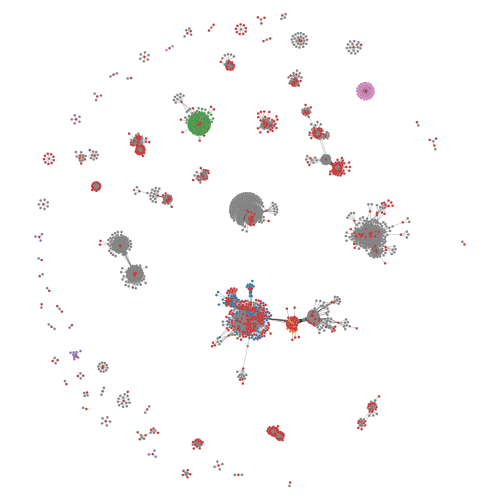

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe5d3b50470, at 0x7fe5ef5b9898>

In [55]:
graph_draw(g, vertex_fill_color=v_prop,output_size=(500, 500))

In [56]:
state_dc = minimize_nested_blockmodel_dl(g, deg_corr=True)

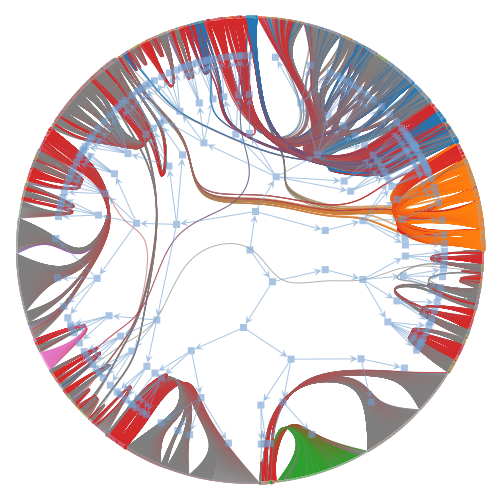

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe5d3b50470, at 0x7fe69c566668>,
 <Graph object, directed, with 3876 vertices and 3875 edges at 0x7fe69c562320>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe69c562320, at 0x7fe69c562fd0>)

In [57]:
draw_hierarchy(state_dc,vertex_fill_color=v_prop,output_size=(500, 500))

In [58]:
#And 1 for saving (with names).
#draw_hierarchy(state_dc,vertex_fill_color=v_prop,vertex_text=name_prop, vertex_font_size=10,output_size=(10000, 10000), output='figures/Bee_tblx_graph_minizenestedblock_NAMES.png')

In [59]:
#And 1 for saving (without names)
#draw_hierarchy(state_dc,vertex_fill_color=v_prop,output_size=(10000, 10000), output='figures/Bee_tblx_graph_minizenestedblock.png')

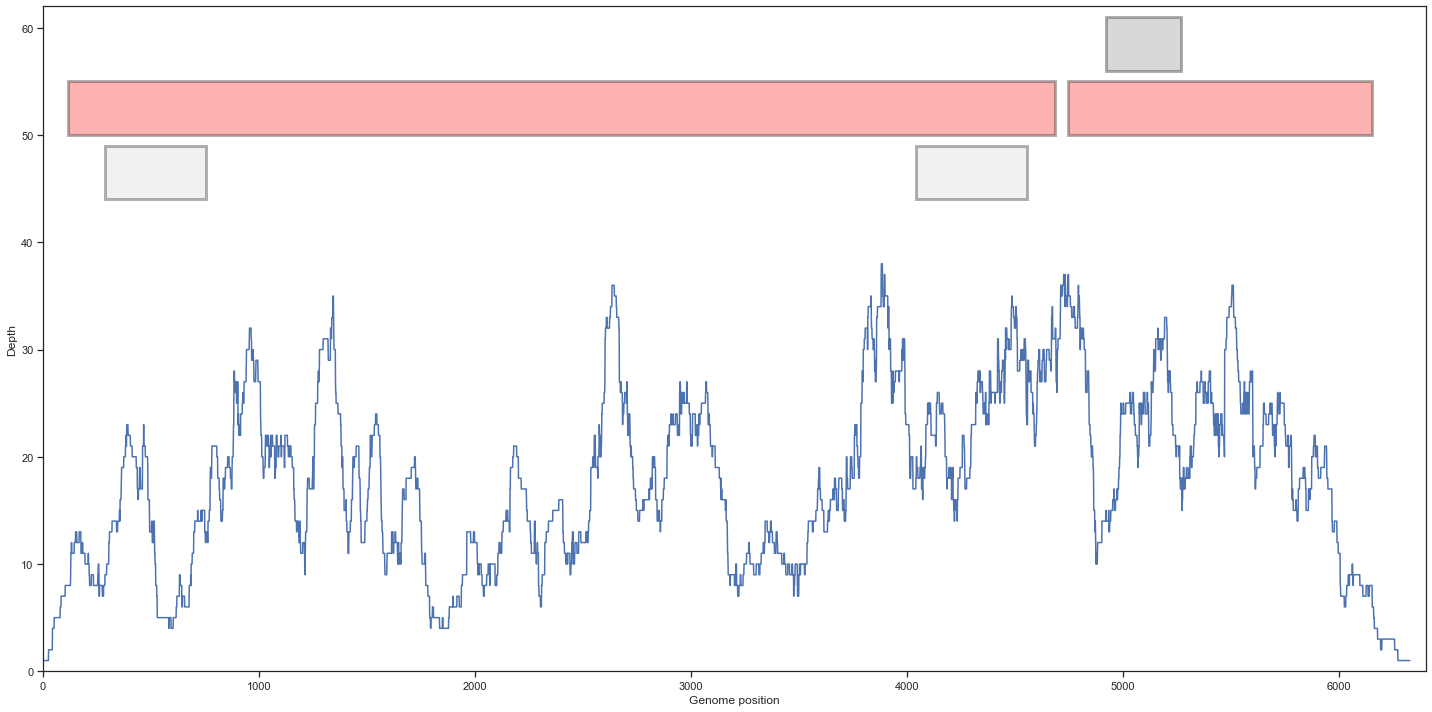

In [62]:
############ Plot the coverage and genome structure of the recombinant astro-lakesinai
pos = []
depth = []
with open('../data/LSVrecomb.depth') as f:
    for line in f:
        pos.append(6328 - int(line.strip().split('\t')[1]))
        depth.append(int(line.strip().split('\t')[2]))
plt.figure(figsize=(20,10))

#ORF1: 118 - 4683 +(Nonstructural protein Culex bastrovirus-like virus 31.26% AA similarity.)
#ORF2: 4744 - 6153 +(Lake sinai virus capsid, 35.50% AA similarity.)
#ORF3: 4919 - 5266 +
#ORF4: 4039 - 4554 -
#ORF5: 289 - 753 -

g = sns.lineplot(pos,depth)
g.set(xlabel="Genome position",ylabel="Depth")
g.set(ylim=(0,62))
g.set(xlim=(0,6400))
g.add_patch(mpatches.Rectangle((4744, 50), 1409, 5, alpha=0.3, facecolor="red", edgecolor="black", linewidth=3, linestyle='solid'))
g.add_patch(mpatches.Rectangle((118, 50), 4565, 5, alpha=0.3, facecolor="red", edgecolor="black", linewidth=3, linestyle='solid'))
g.add_patch(mpatches.Rectangle((4919, 56), 347, 5, alpha=0.3, facecolor="grey", edgecolor="black", linewidth=3, linestyle='solid'))
g.add_patch(mpatches.Rectangle((4039, 44), 515, 5, alpha=0.3, facecolor="lightgrey", edgecolor="black", linewidth=3, linestyle='solid'))
g.add_patch(mpatches.Rectangle((289, 44), 464, 5, alpha=0.3, facecolor="lightgrey", edgecolor="black", linewidth=3, linestyle='solid'))
g
#g.figure.savefig('figures/LSVrecomb.png', dpi=300)